# Water Allocation Simulation Analysis
This notebook provides tools to analyze the results of the water allocation simulation
across multiple scenarios, focusing on ecological and economic impacts under different
conditions.

## Overview
The simulation tests water allocation policies across various scenarios with different:
- River basins (station configurations)
- Actor compositions
- Water scarcity levels
- Forecast error profiles (bias and uncertainty)

The analysis evaluates how these factors affect both ecological integrity and economic benefits.


In this notebook we will:
1. Run the set of evaluation scenarios varying station size, scarcity level,  
   forecast bias and uncertainty.
2. Collect ecological and economic impact metrics for each run.
3. Visualize trade-offs and explore how model parameters influence outcomes.

In [14]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from types import MethodType
import src.core as wms
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import src.scenarios as sc
import src.plot_multi_analysis as pma

# Set better visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [15]:
custom_quota = eqp.hard_quota

# Define incentive policy - uses fines and subsidies to influence actor behavior
def custom_incentive_policy(self,
                    actions: np.ndarray,
                    actors_priority: np.ndarray,
                    avg_incomes: np.ndarray,
                    water_pump: np.ndarray,
                    avg_pump: np.ndarray,
                    is_crisis: np.ndarray,
                    water_flows: np.ndarray,
                    quota: np.ndarray,
                    DOE = 15,
                    DCR = 10) -> np.ndarray:
    """
    Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
    
    Returns an array of incentives (positive values = fines, negative values = subsidies)
    """
    fine = np.zeros(self.nb_actors)
    stress = is_crisis[-1]  # Current crisis level
    
    # If average income is negative, replace it with 0
    avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)
    
    for i in range(self.nb_actors):
        # Apply heavy fine if exceeding quota during crisis
        if (water_pump[i] > quota[i]) and (actors_priority[i] <= stress):
            fine[i] = avg_incomes[i] * 8 + 8
        # Give small subsidy to low priority actors who respect their quota
        elif (water_pump[i] <= quota[i]) and (actors_priority[i] < stress):
            fine[i] = - 10000
    return fine

## Scenario Definition
Runs simulations across the pre-defined scenarios.
We iterate over:
- **Stations**: Tarn vs. La Vézère  
- **Scarcity levels**: low / medium / high  
- **2 set of actors and variant with heterogenous biaises and uncertainties**  
- **Forecast bias/uncertainty** settings  

Execute the next cell to proceed multo-scenario analysis.

In [16]:
if False:
    results_df = sc.run_all_scenarios(
        turns=700,
        iterations=5,
        custom_incentive_policy=custom_incentive_policy,
        custom_quota=custom_quota)
    results_df.to_csv('results_high_coop_df.csv', index=False)
else:
# load results_df from csv
    results_df = pd.read_csv('./multi_exec/results_high_coop_df.csv')


## Multi-Scenario Analysis


### Ecological vs. economic impact.

respectful_sim : 177
disrespectful_sim : 39


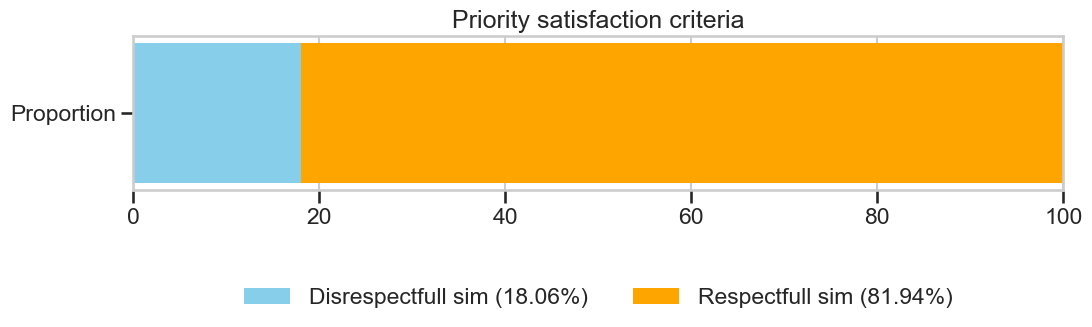

In [17]:
respectfull_sim = len(results_df[results_df["priority_ok"] == 1])
disrespectfull_sim = len(results_df[results_df["priority_ok"] == 0])
disrespectfull_proportion = round((disrespectfull_sim / (disrespectfull_sim + respectfull_sim)) * 100,2)
respectfull_proportion = round((respectfull_sim / (disrespectfull_sim + respectfull_sim)) * 100, 2)

print("respectful_sim :", respectfull_sim)
print("disrespectful_sim :", disrespectfull_sim)

fig, ax = plt.subplots(figsize=(12, 2))

# Affiche une barre horizontale avec deux segments empilés
ax.barh(y=["Proportion"], width=disrespectfull_proportion, color='skyblue', label=f"Disrespectfull sim ({disrespectfull_proportion}%)")
ax.barh(y=["Proportion"] , width=respectfull_proportion, left=disrespectfull_proportion, color='orange', label=f"Respectfull sim ({respectfull_proportion}%)")

# Ajout des labels
ax.set_xlim(0, 100)
ax.set_title("Priority satisfaction criteria")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=2)


plt.show()

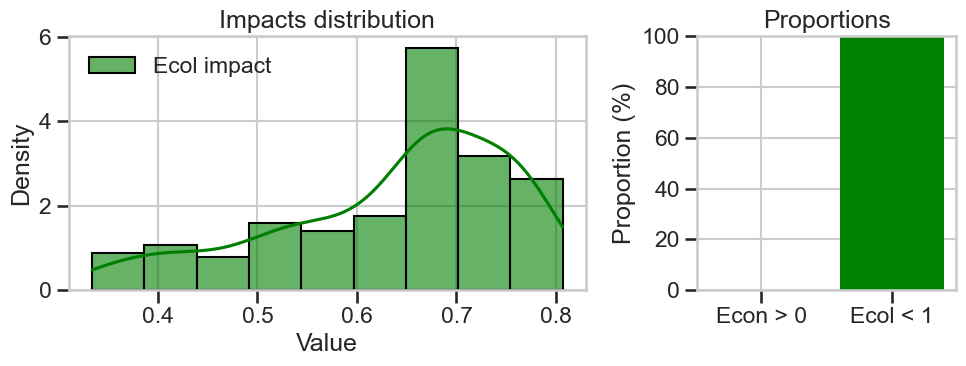

In [27]:
data_len = len(results_df)
sup_zero_econ_proportion = round((len(results_df[results_df["economic_impact"] > 0]) / data_len) * 100, 2)
sub_1_ecol_proportion = round((len(results_df[results_df["ecological_impact"] < 1]) / data_len) * 100, 2)

global_econ_impact_distrib = results_df["economic_impact"]
global_ecol_impact_distrib = results_df["ecological_impact"]


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Prépare la figure avec deux sous-graphiques côte à côte
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 2:1 ratio

# 1. Graphique des distributions superposées
ax0 = plt.subplot(gs[0])
# sns.histplot(global_econ_impact_distrib, kde=True, color="orange", label="Econ impact", ax=ax0, stat="density", alpha=0.6)
sns.histplot(global_ecol_impact_distrib, kde=True, color="green", label="Ecol impact", ax=ax0, stat="density", alpha=0.6)
ax0.set_title("Impacts distribution")
ax0.set_xlabel("Value")
ax0.legend()

# 2. Graphique en barres des proportions
ax1 = plt.subplot(gs[1])
ax1.bar(["Econ > 0", "Ecol < 1"], [sup_zero_econ_proportion, sub_1_ecol_proportion], color=["orange", "green"])
ax1.set_ylim(0, 100)
ax1.set_ylabel("Proportion (%)")
ax1.set_title("Proportions")

plt.tight_layout()
plt.show()


Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact
Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact
Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact


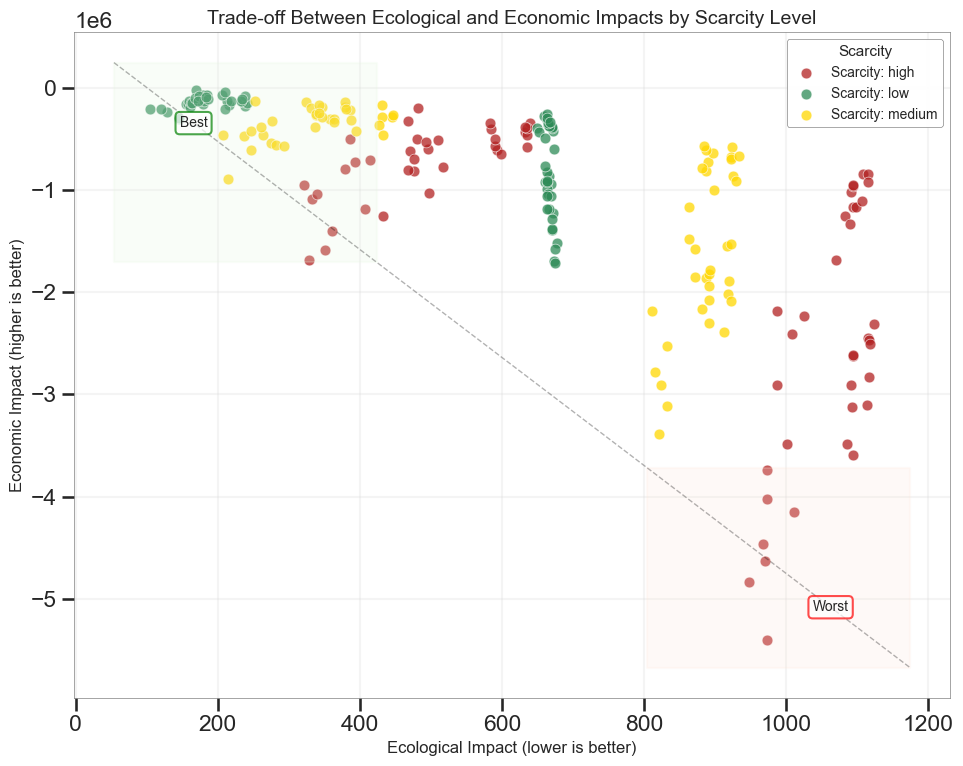

Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact
Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact


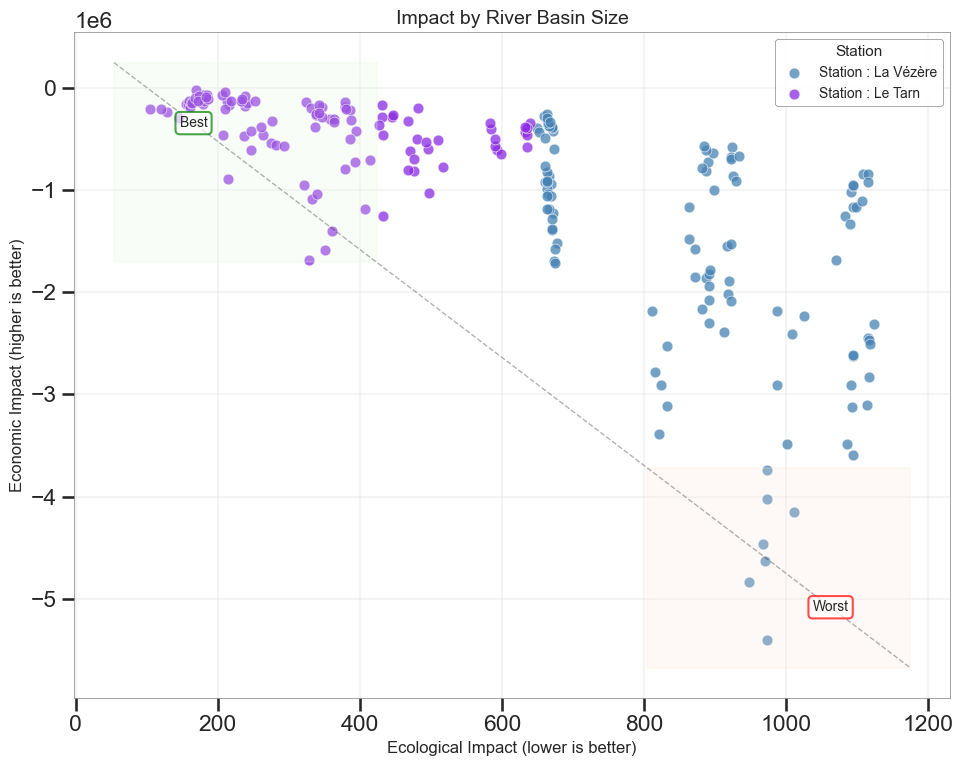

Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact
Label utilisé pour écolo :  raw_ecological_impact
Label utilisé pour écon :  raw_economic_impact


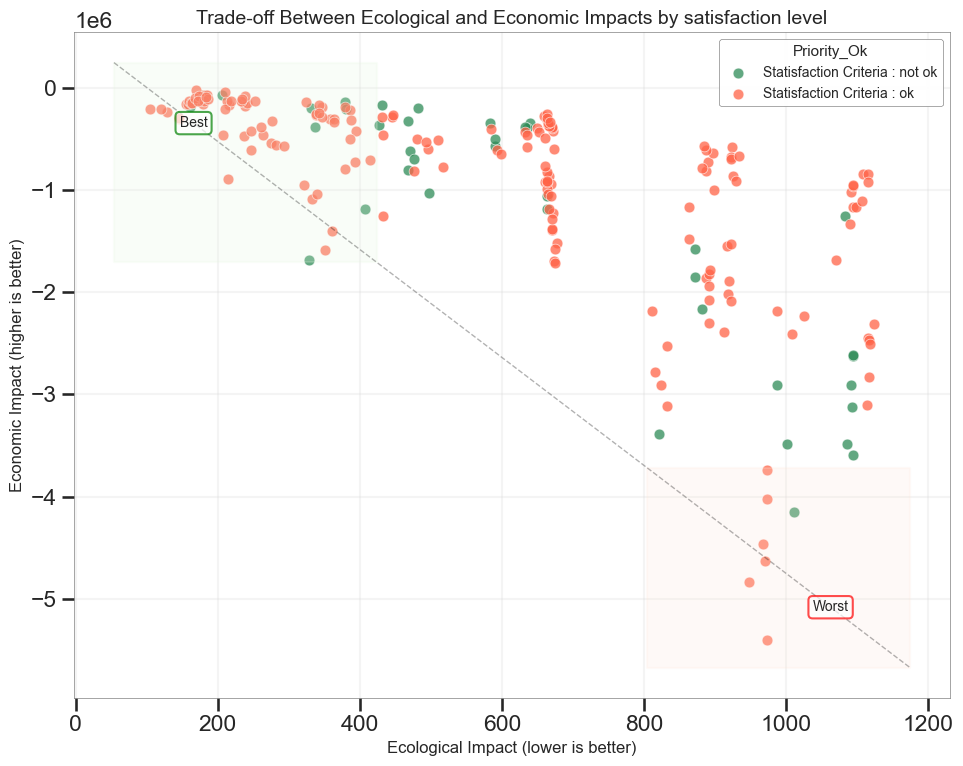

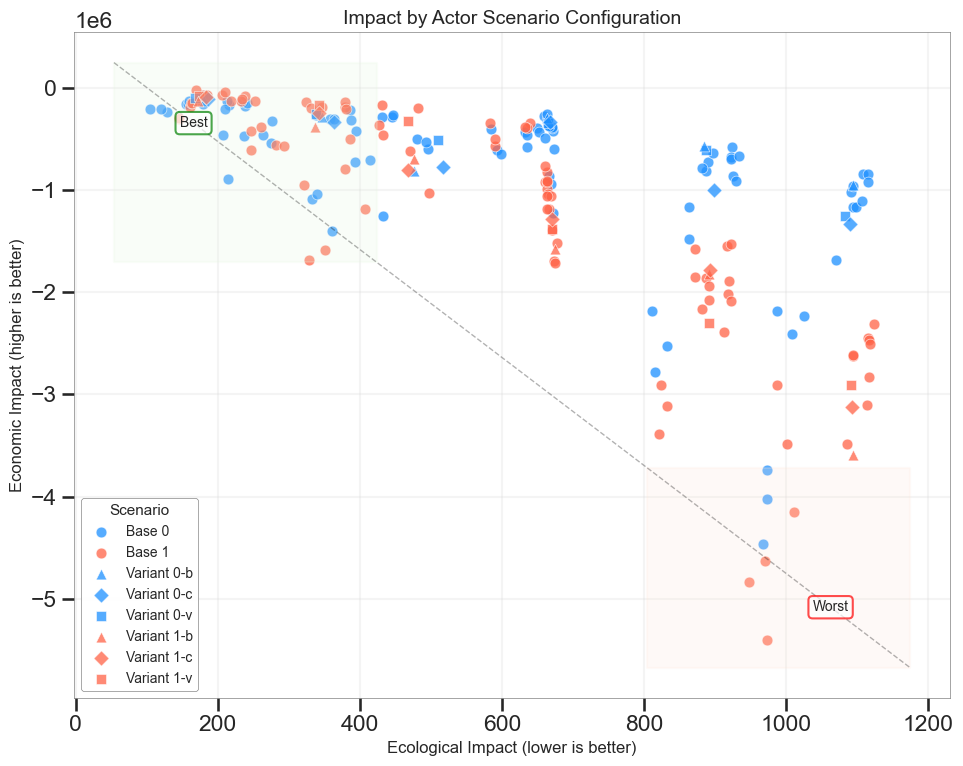

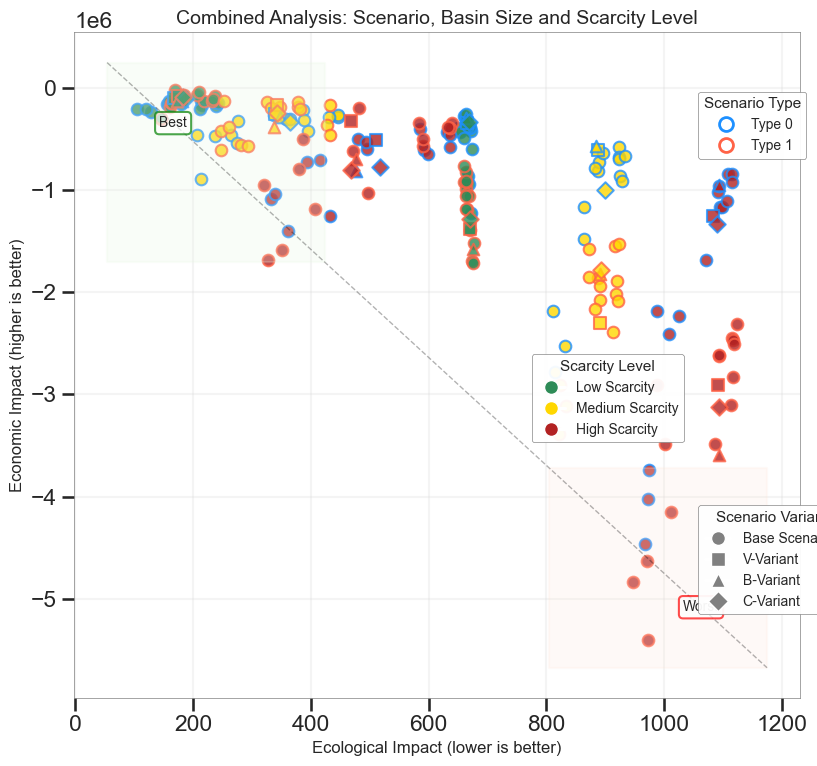

In [19]:
pma.analyze_scenario_impacts(results_df)

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


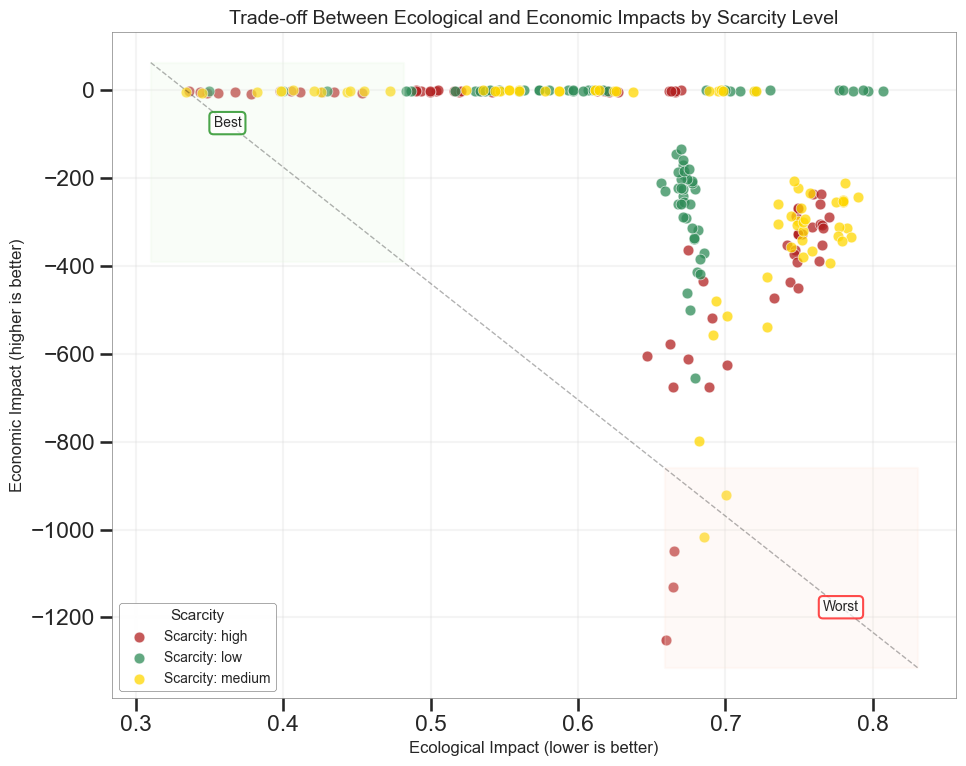

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


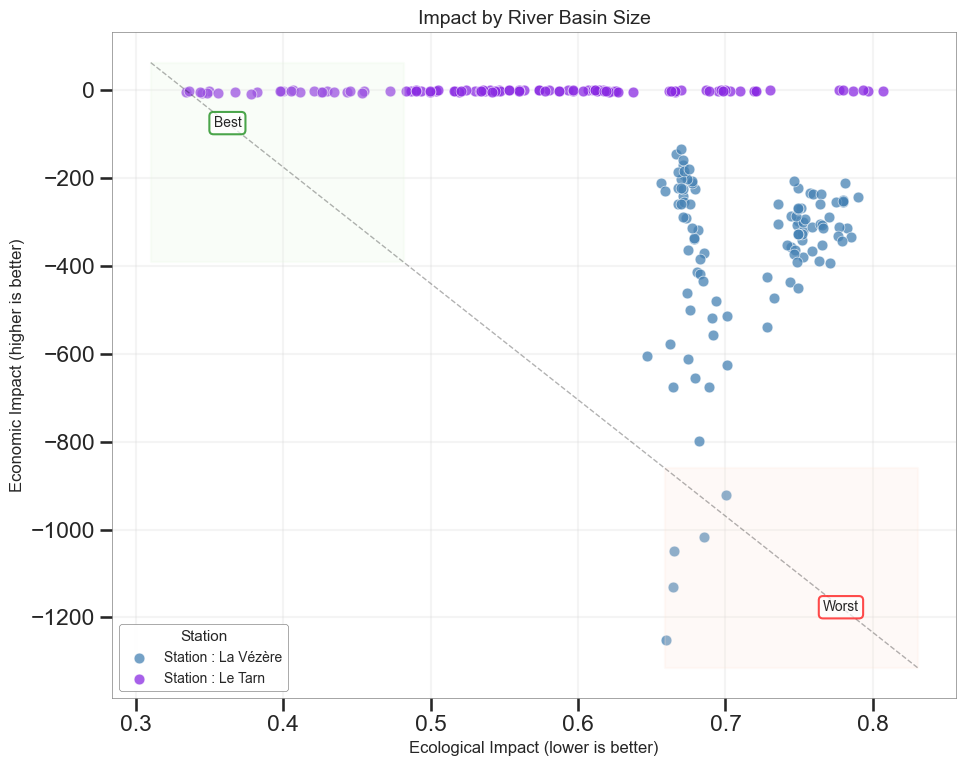

Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact
Label utilisé pour écolo :  ecological_impact
Label utilisé pour écon :  economic_impact


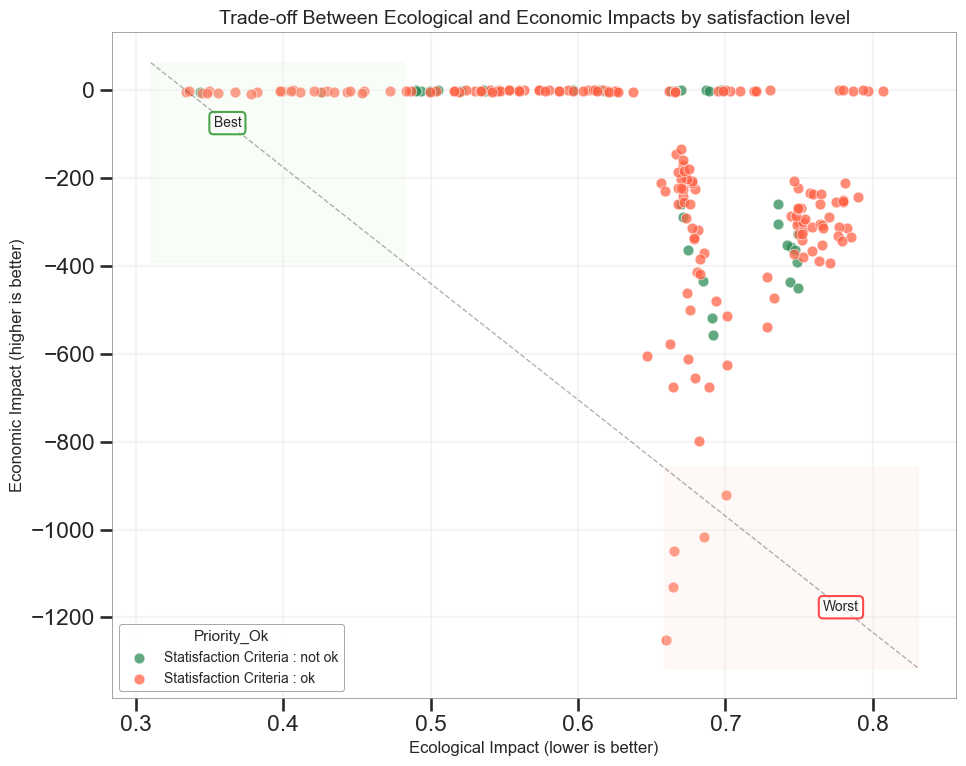

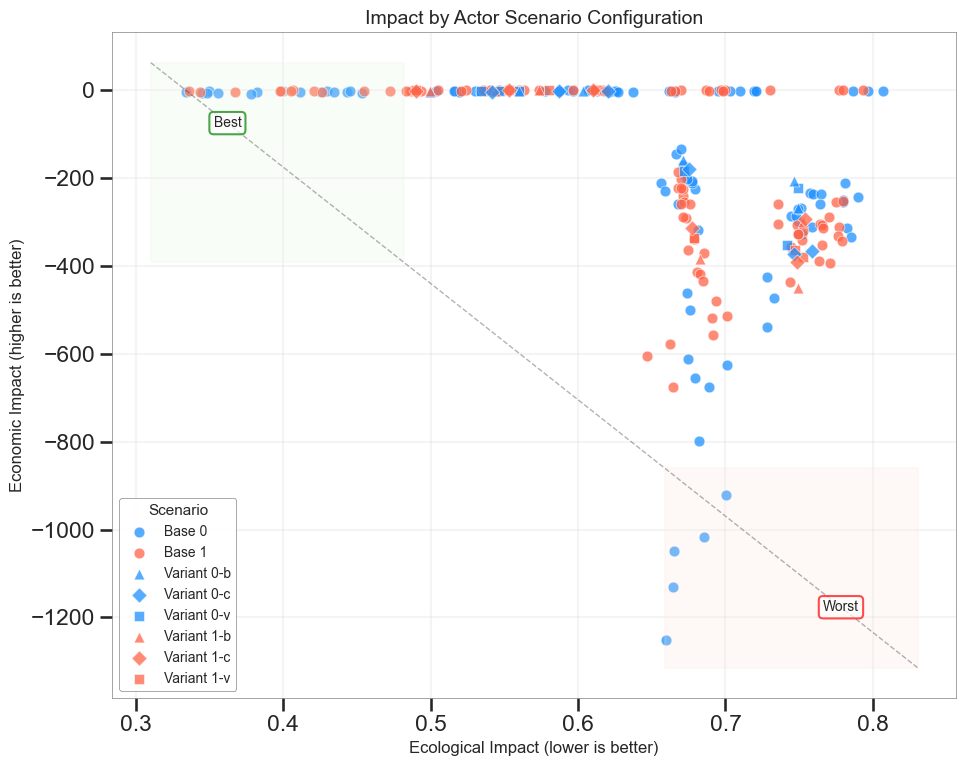

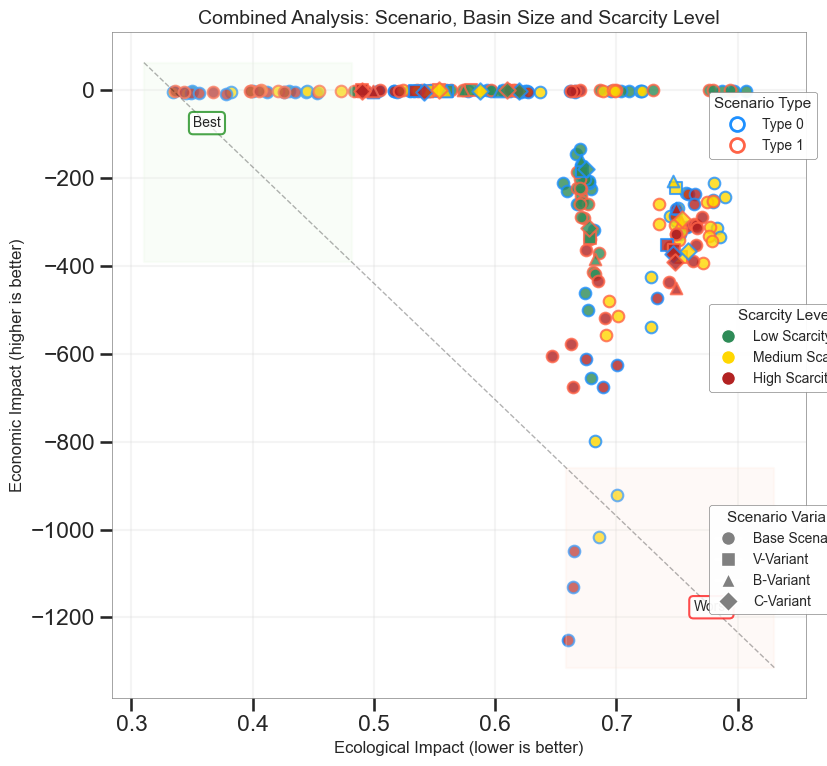

In [20]:
pma.analyze_scenario_impacts(results_df , is_scalled=True)

## Analyzing Forecast Bias & Uncertainty & Scarcity levels

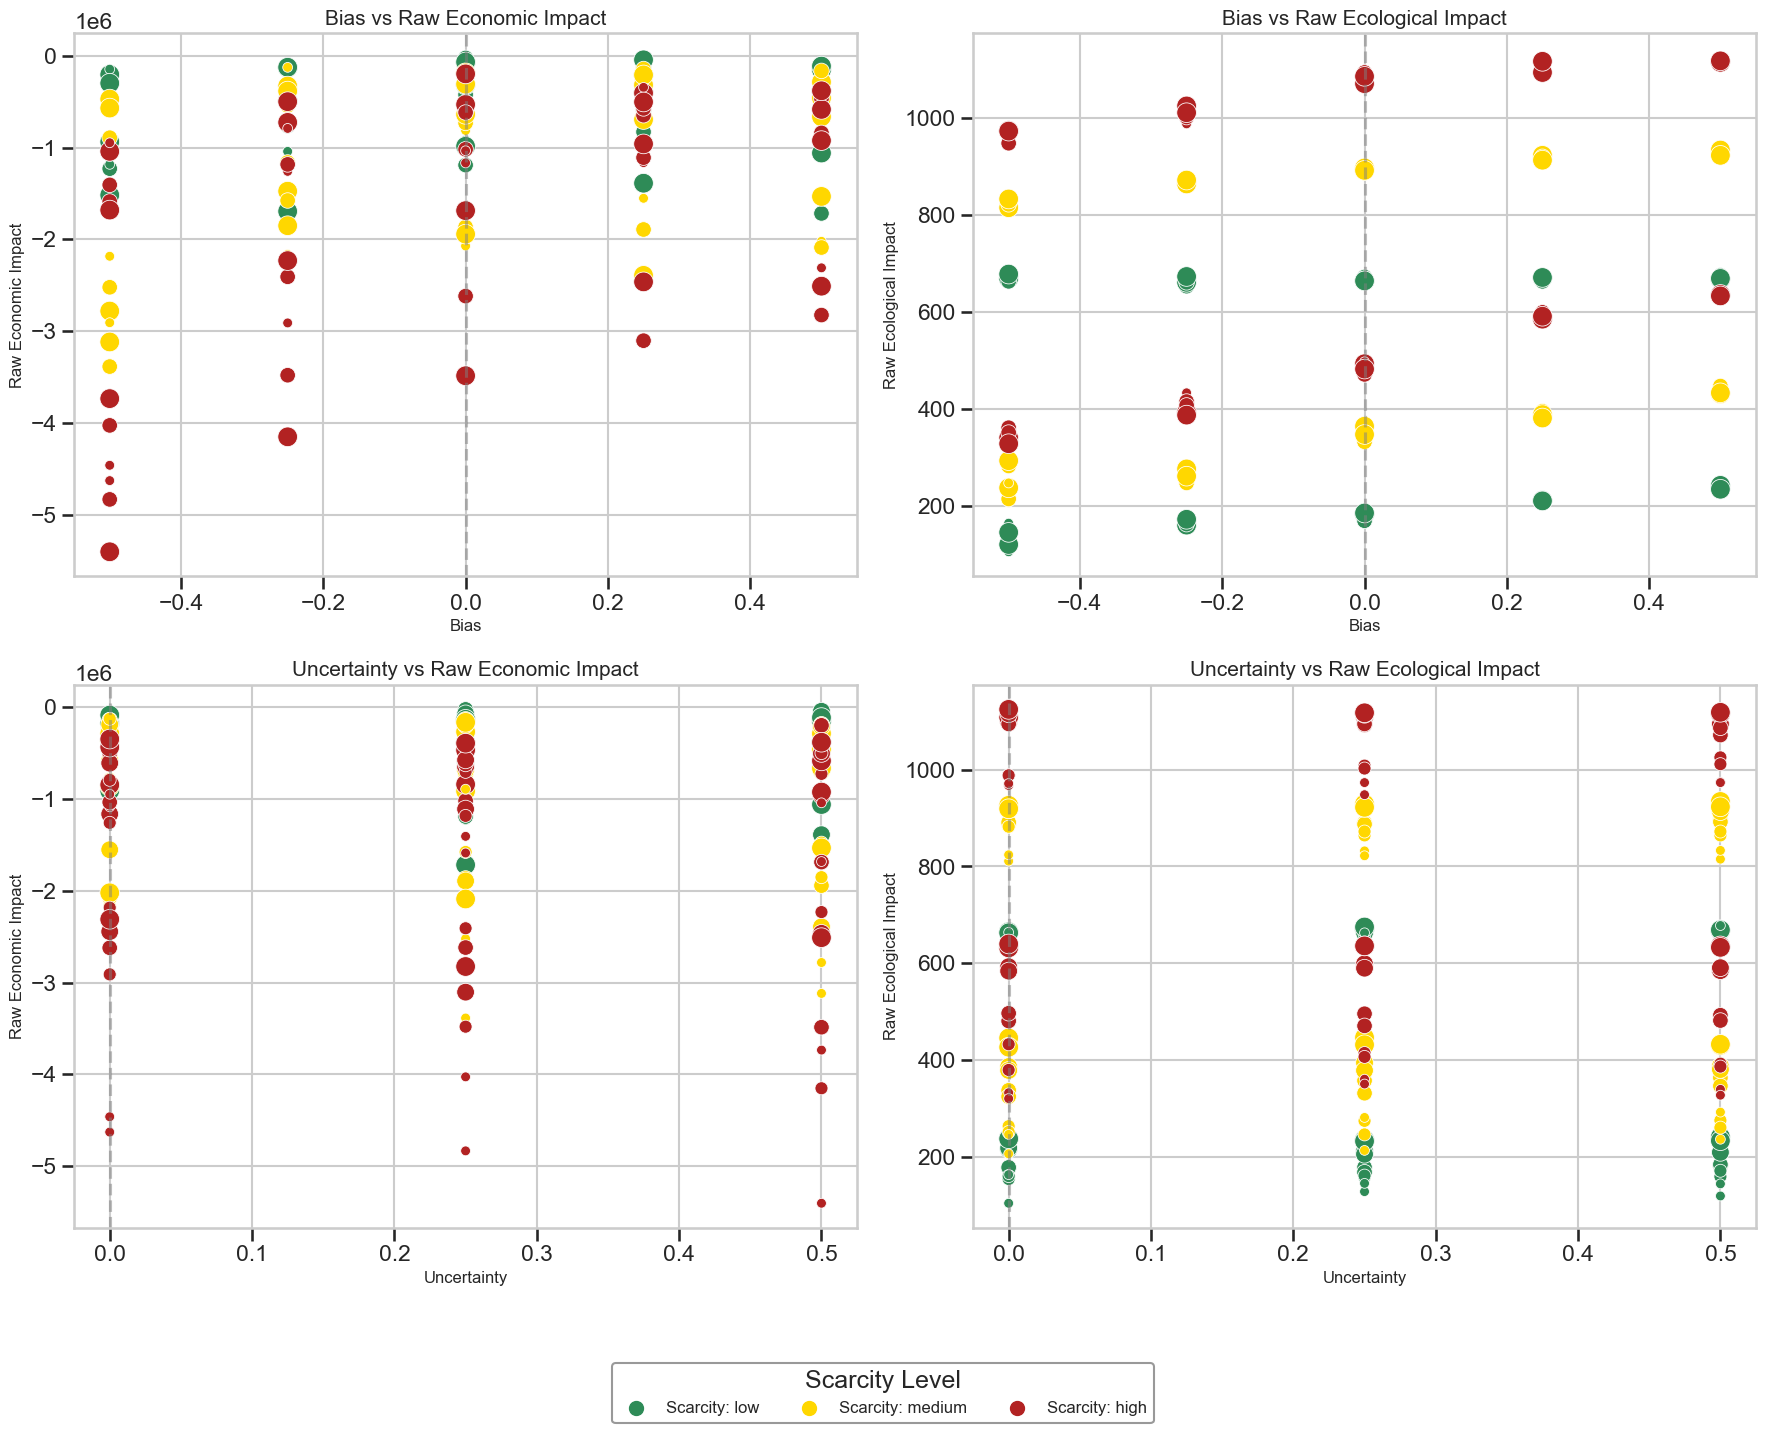

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:351: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


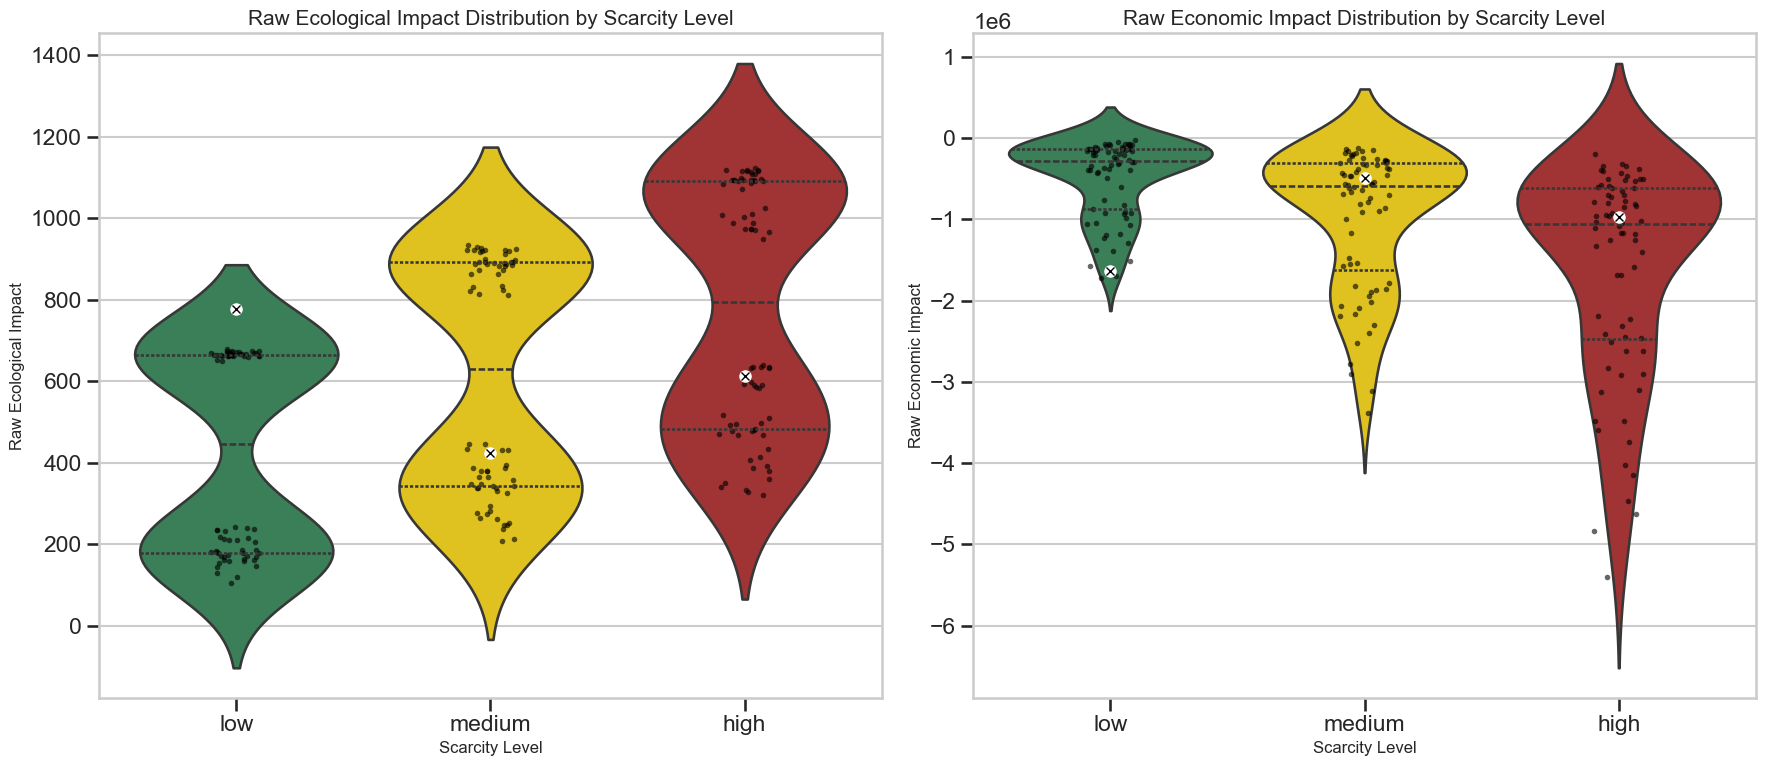

In [21]:
pma.analyze_forecast_effects(results_df)

## Correlation Analysis


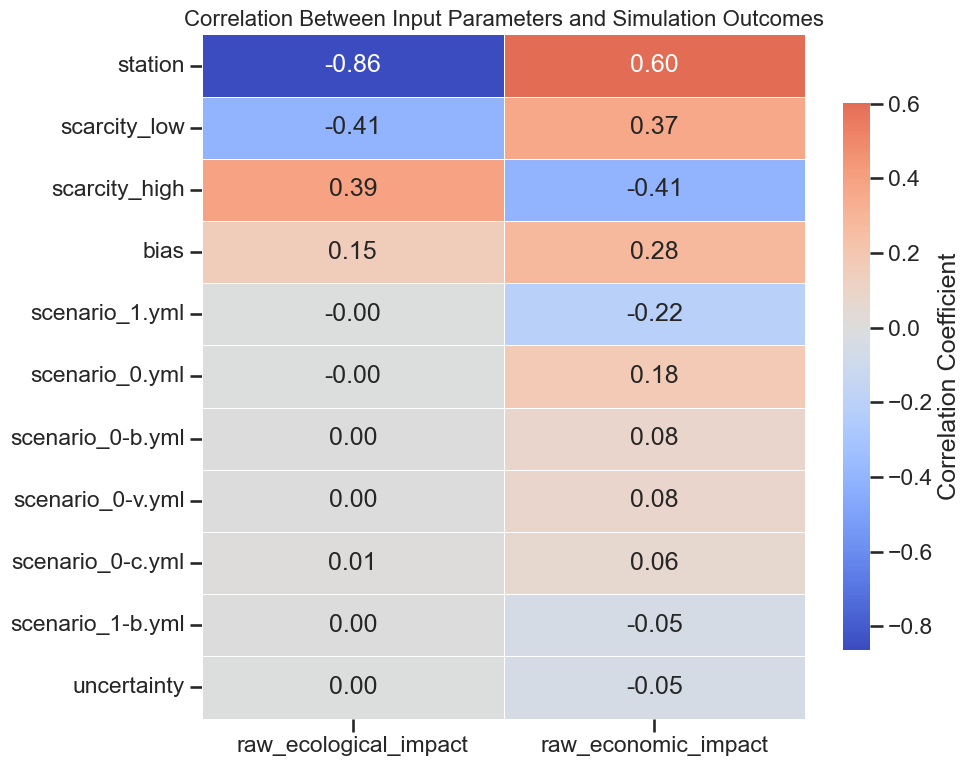


Top impacts on raw_ecological_impact:

Top 5 positive correlations:
  scarcity_high: 0.392
  bias: 0.153
  scarcity_medium: 0.017
  scenario_0-c.yml: 0.009
  scenario_0-v.yml: 0.002

Top 5 negative correlations:
  uncertainty: 0.000
  scenario_1.yml: -0.003
  scenario_0.yml: -0.003
  scarcity_low: -0.409
  station: -0.864

Top impacts on raw_economic_impact:

Top 5 positive correlations:
  station: 0.602
  scarcity_low: 0.367
  bias: 0.277
  scenario_0.yml: 0.176
  scenario_0-b.yml: 0.085

Top 5 negative correlations:
  scenario_1-c.yml: -0.031
  uncertainty: -0.053
  scenario_1-b.yml: -0.054
  scenario_1.yml: -0.216
  scarcity_high: -0.406


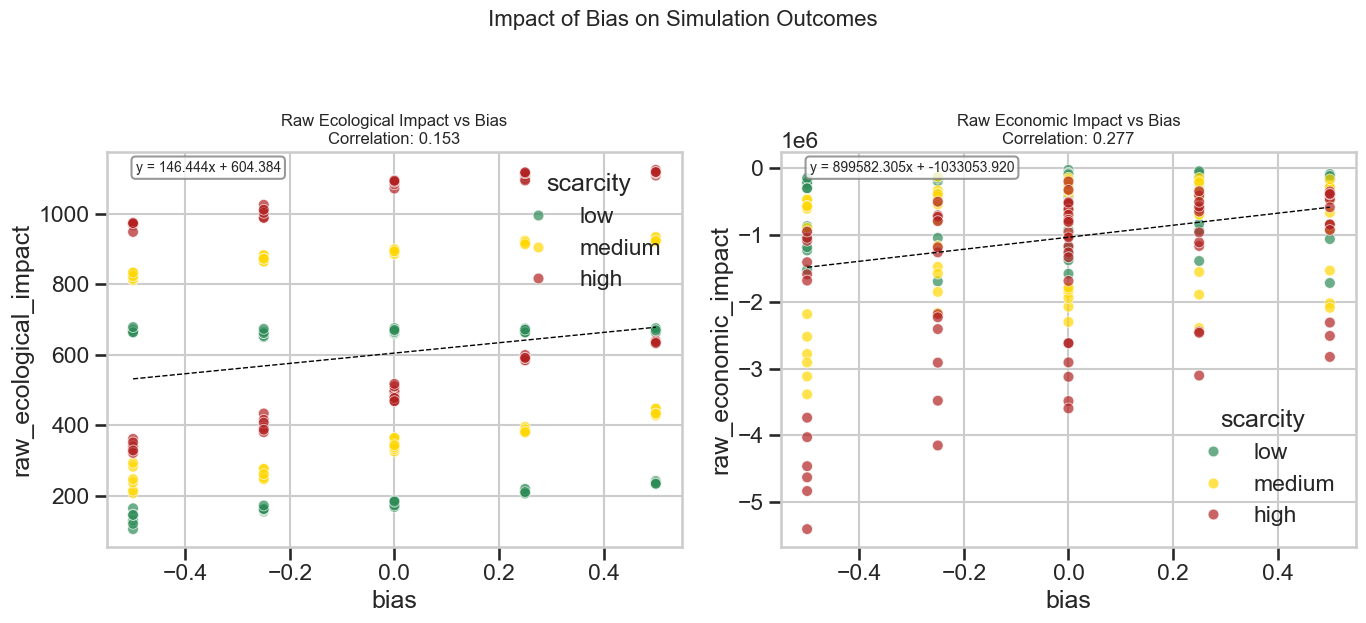

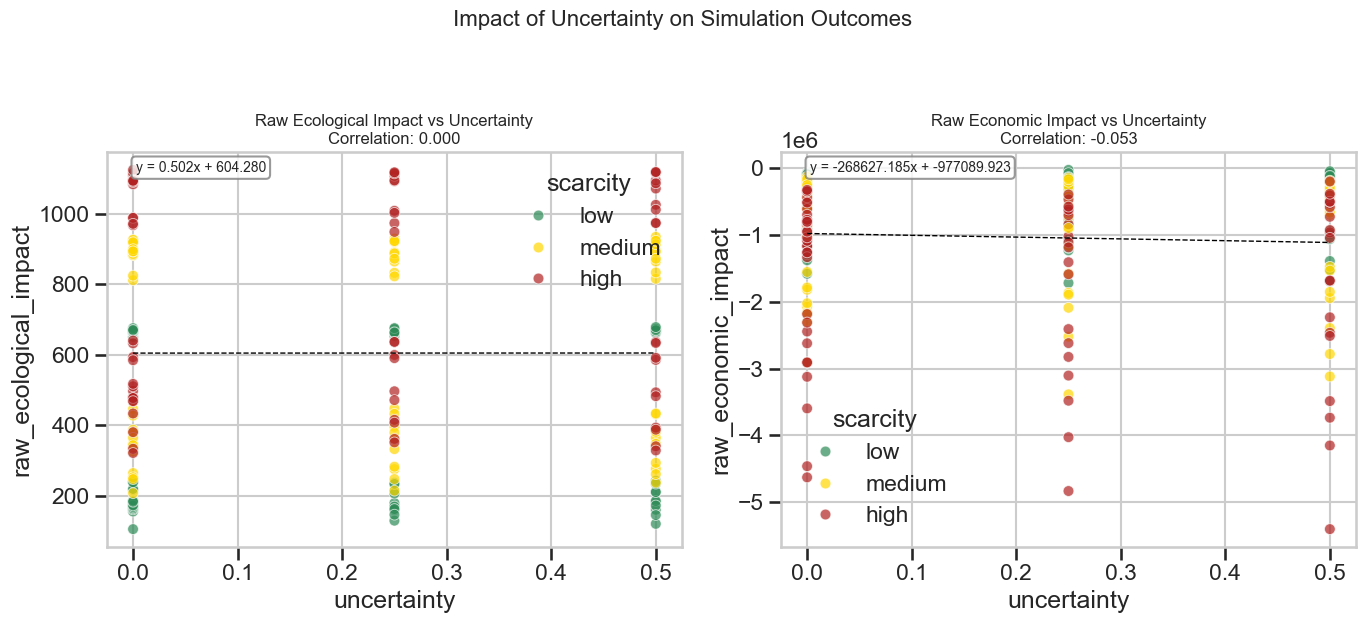

<Figure size 1200x1000 with 0 Axes>

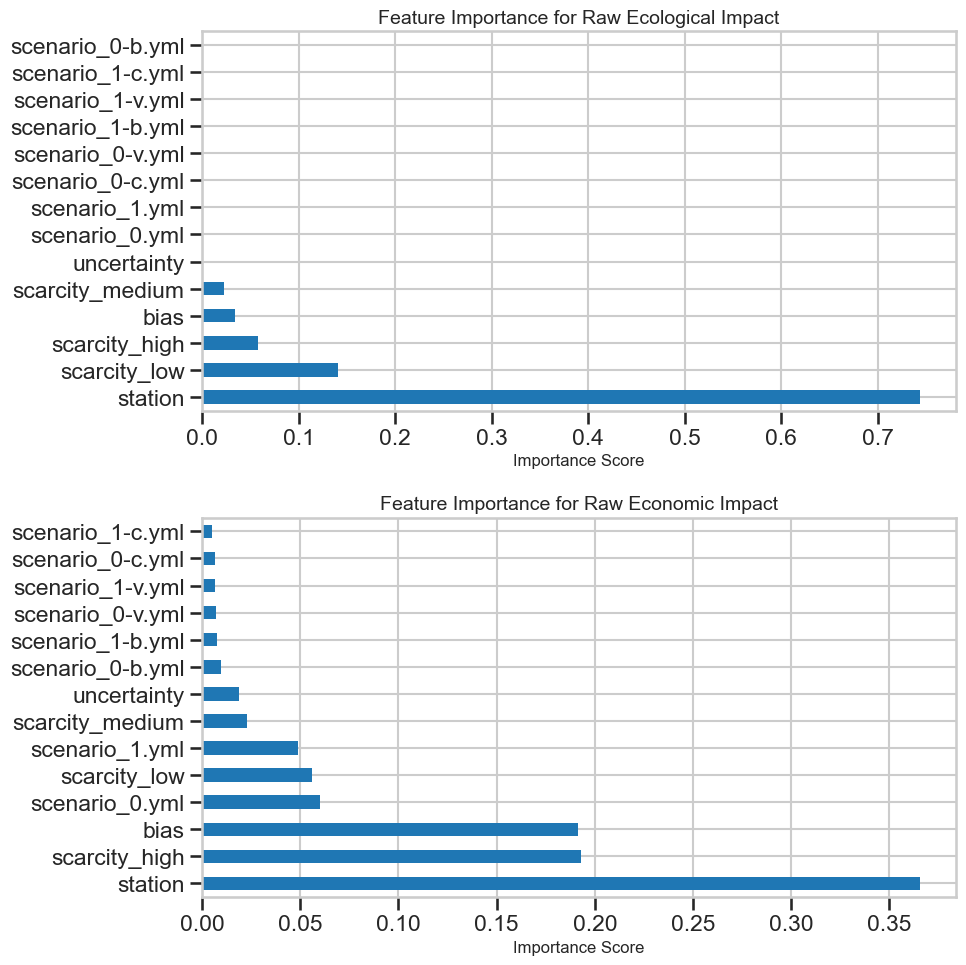

In [22]:
pma.correlation_analysis(results_df)

## Cooperation Analysis
Analyzing cooperation patterns across scenarios and their impact on ecological and economic outcomes.

c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon.Phase2\WaterScarcity.Hackathon\src\plot_multi_analysis.py:993: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


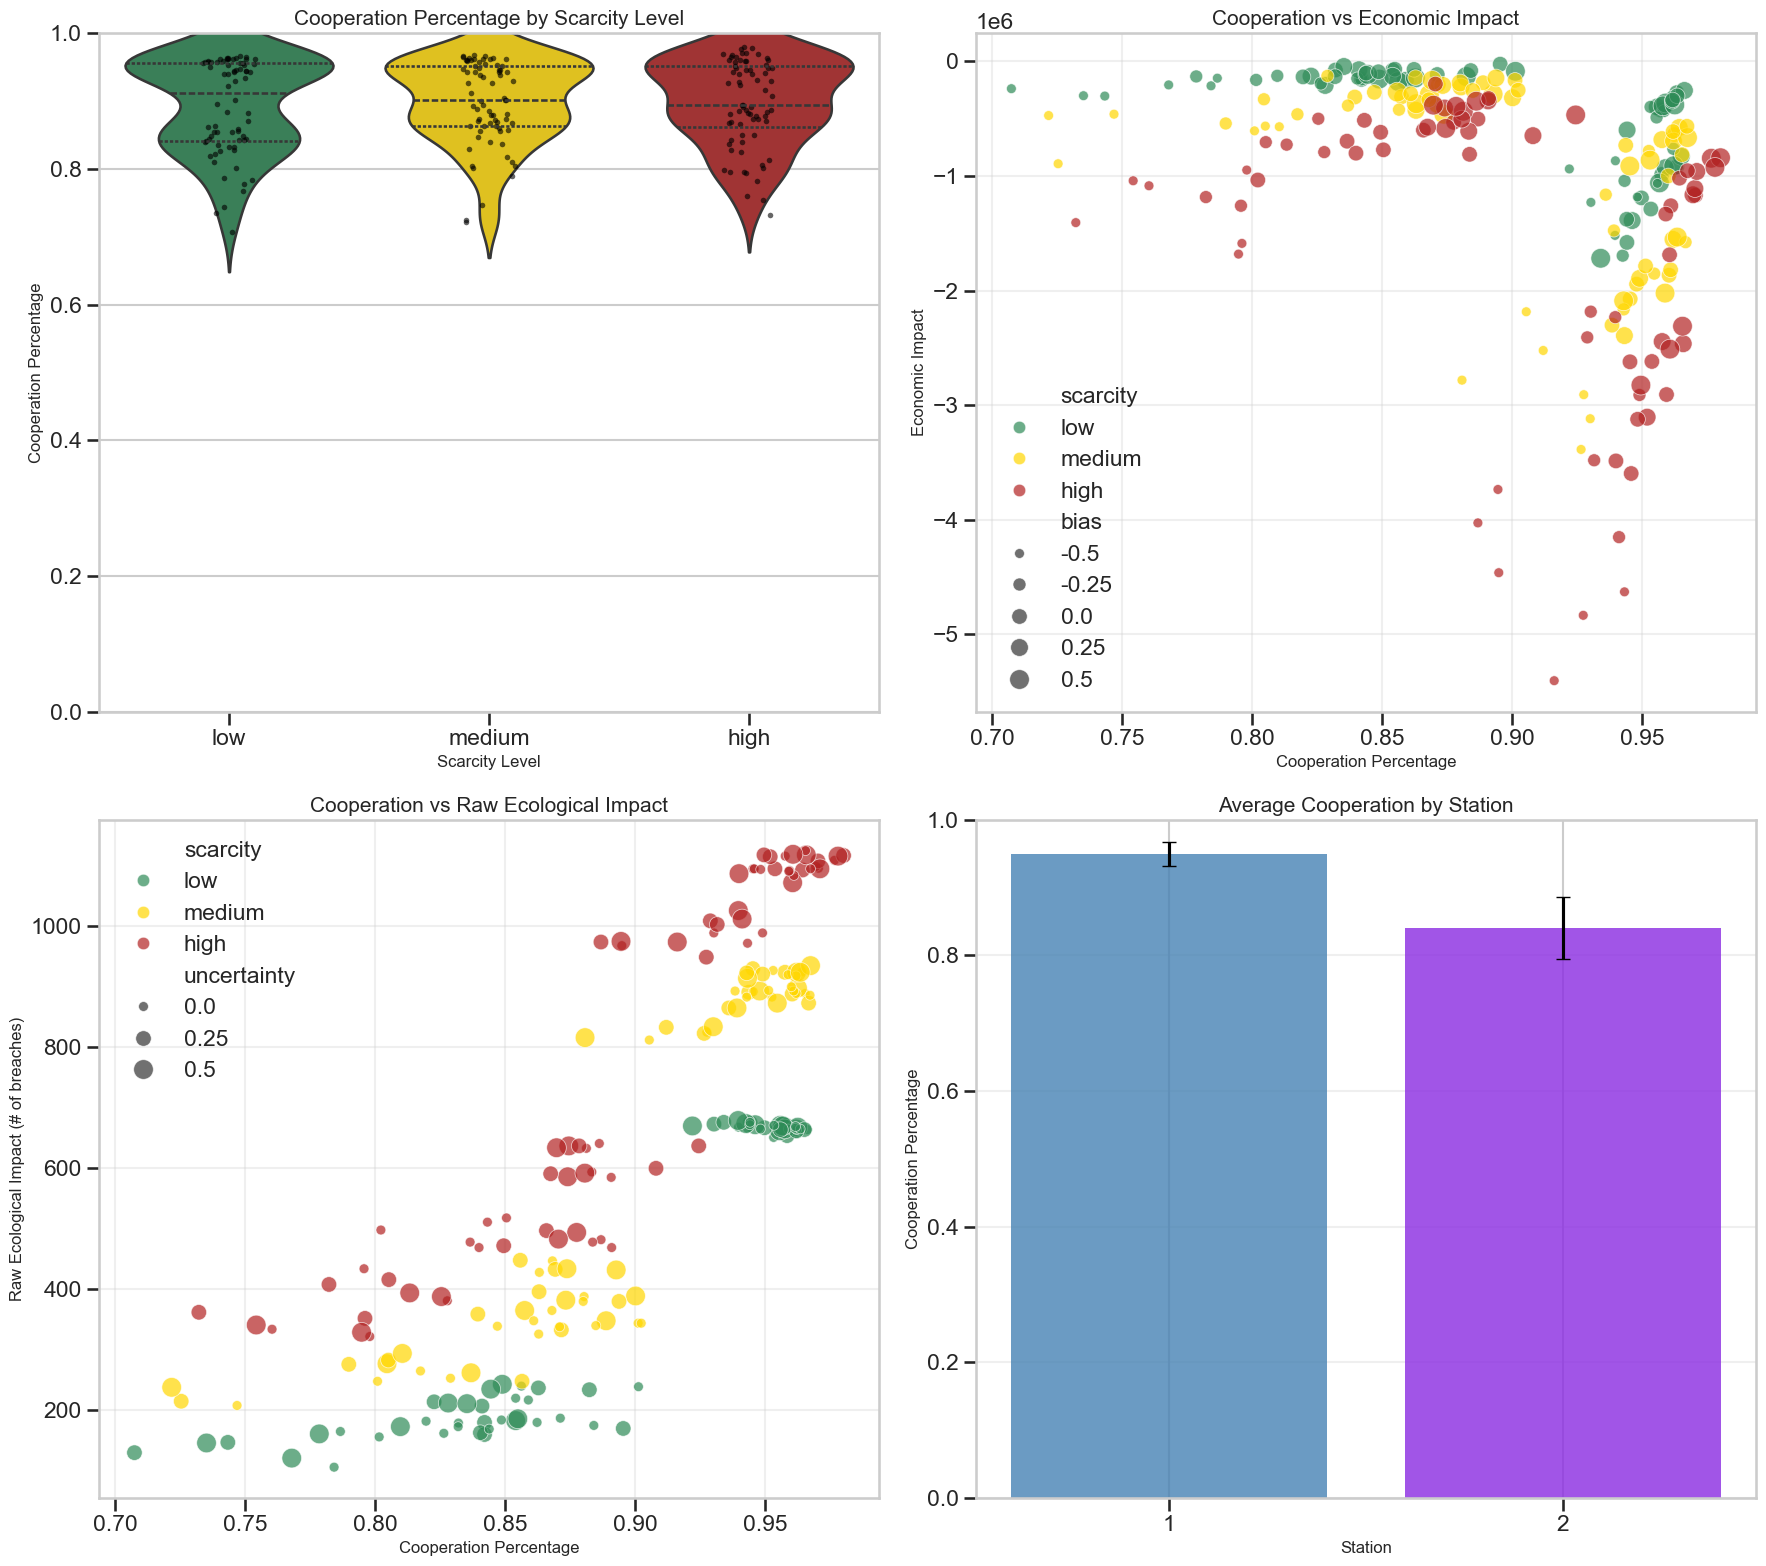

In [23]:
pma.analyze_cooperation_patterns(results_df)

## Raw Impact Vs Scalled Impact
Analyzing the raw (unscaled) ecological / economic impact against scalled impacts 

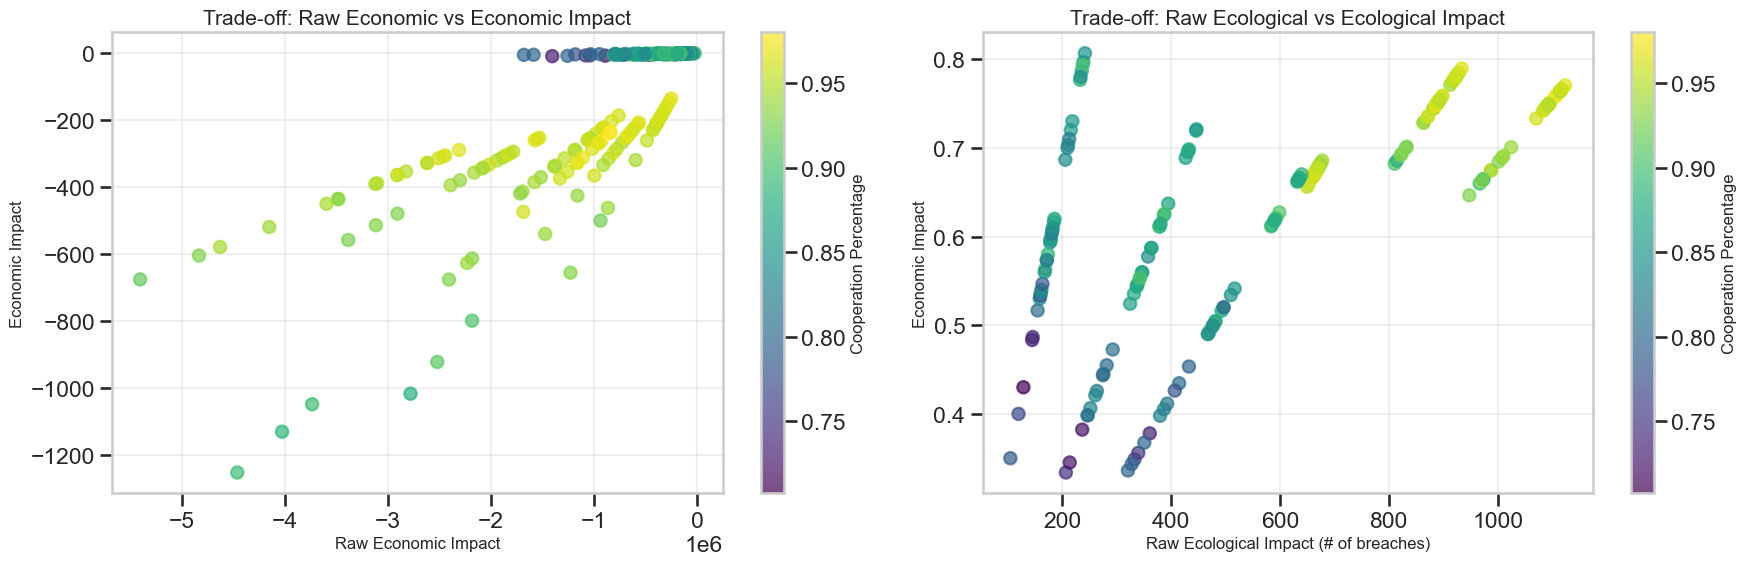

In [24]:
pma.analyze_raw_impact(results_df)

## Cooperation by Forecast Parameters
Analyzing how forecast bias and uncertainty affect cooperation levels.


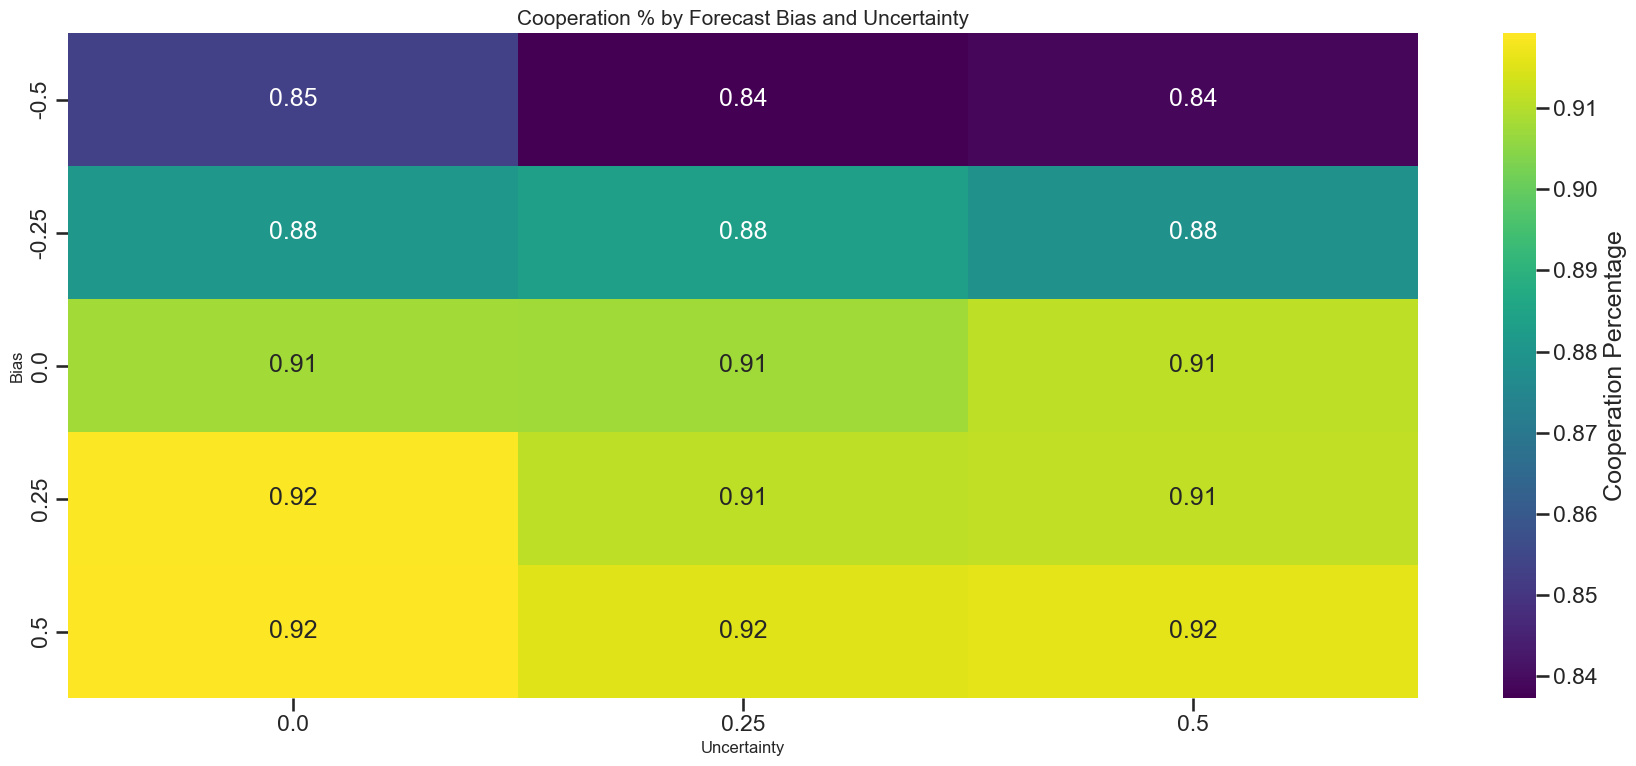

In [25]:
pma.analyze_cooperation_by_forecast_params(results_df)

## Comprehensive Analysis
Performing a comprehensive analysis of all metrics and their relationships.


=== Summary Statistics ===

Overall Metrics:
Average Cooperation: 0.90
Average Raw Ecological Impact: 604.4 breaches
Average Scaled Ecological Impact: 0.636
Average Economic Impact: -1033053.920

Correlation Matrix:
                        cooperation_percentage  raw_ecological_impact  \
cooperation_percentage                    1.00                   0.81   
raw_ecological_impact                     0.81                   1.00   
ecological_impact                         0.81                   0.68   
economic_impact                          -0.55                  -0.73   
raw_economic_impact                      -0.37                  -0.69   
bias                                      0.36                   0.15   
uncertainty                              -0.06                   0.00   

                        ecological_impact  economic_impact  \
cooperation_percentage               0.81            -0.55   
raw_ecological_impact                0.68            -0.73   
ecological_im

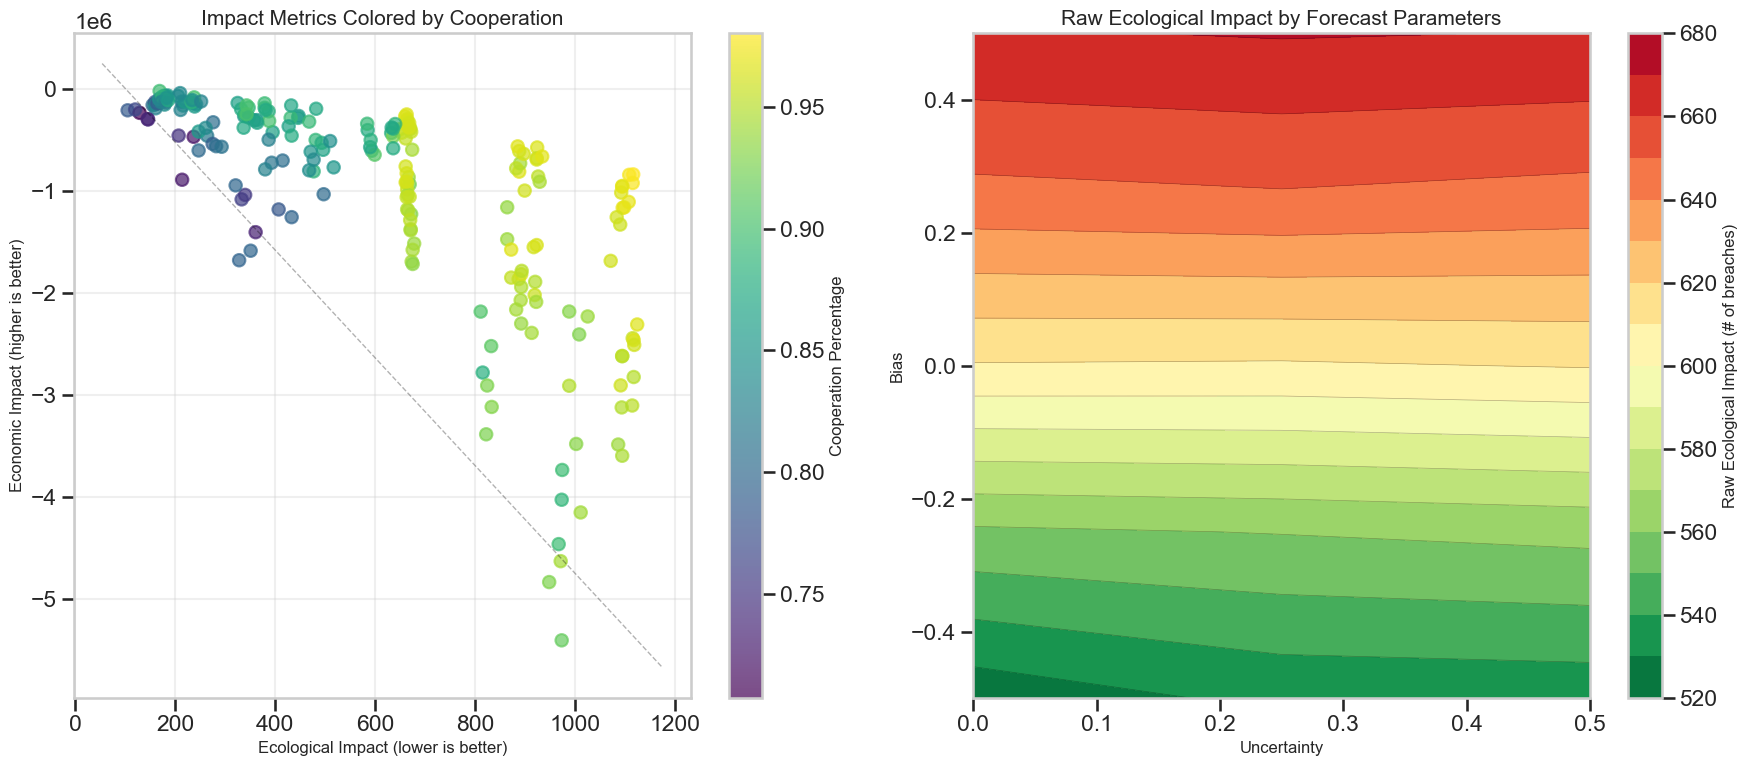

In [26]:
pma.comprehensive_analysis(results_df)

## Conclusion
This notebook has demonstrated how to analyze water allocation policies across multiple scenarios,
focusing on the balance between ecological and economic impacts. To participate in the hackathon:

1. Design your own adaptive policy by modifying the `custom_incentive_policy` and `custom_quota` functions
2. Test your policy across multiple scenarios using the tools provided
3. Optimize your policy to balance ecological integrity and economic benefits

Good luck!